# [IEEE Fraud Detection Competition](https://www.kaggle.com/c/ieee-fraud-detection/overview)

From the [competition overview](https://www.kaggle.com/c/ieee-fraud-detection/overview):

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.

If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

## Goal: 
- Basic exploritory data analysis on the IEEE Fraud Detection dataset.
- Feature Engineering and Using LGBM to Make a Prediction

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

# 1. Data

In the competition I am predicting the probability that an online transaction is fraudulent, as denoted by the binary target is Fraud.

The data is broken into two files identity and transaction, which can be joined by TransactionID. 

### 1.1 Read the data

In [7]:
%%time
# Transaction CSVs
train_transaction = pd.read_csv('./data/train_transaction.csv')
test_transaction = pd.read_csv('./data/test_transaction.csv')

# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('./data/train_identity.csv')
test_identity = pd.read_csv('./data/test_identity.csv')

# Sample Submissions
ss = pd.read_csv('./data/sample_submission.csv')

CPU times: user 25.5 s, sys: 4.4 s, total: 29.9 s
Wall time: 30.3 s


In [8]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [21]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# list(train_transaction.columns)
# list(train_identity.columns) - note "DeviceType" and "DeviceInfo"

In [13]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


### 1.2 Exam the link between transaction and identity data

In [14]:
# Here we confirm that all of the transactions in `train_identity`
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907


24.4% of TransactionIDs in train (144233 / 590540) have an associated train_identity.  
28.0% of TransactionIDs in test (144233 / 590540) have an associated train_identity.

This indicates that not all transactions have corresponding identity information.

### 1.3 Data Split on "TransactionDT" (Time Series)

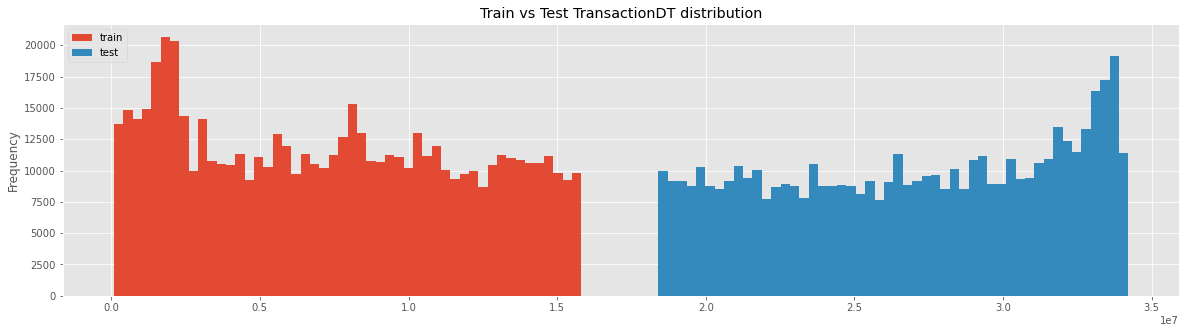

In [17]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(20, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

We can see that train and test data are split by transactionDT. The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp). One early discovery about the data is that the train and test appear to be split by time. There is a slight gap inbetween, but otherwise the training set is from an earlier period of time and test is from a later period of time. This will impact which cross validation techniques should be used.

We will look into this more when reviewing differences in distribution of features between train and test.

### 1.4 Target Distribution

In [24]:
#Check class imbalance

train_transaction['isFraud'].value_counts(normalize=True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

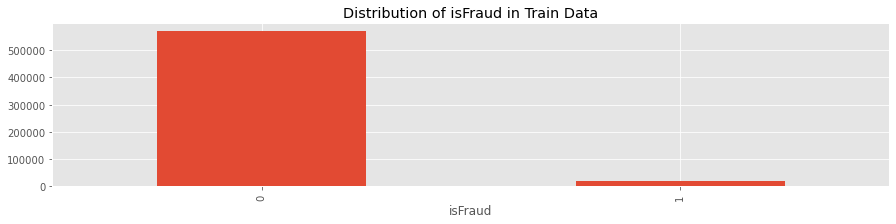

In [36]:
train_transaction.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='bar',
          title='Distribution of isFraud in Train Data',
          figsize=(15, 3))
plt.show()

Heavily imbalanced class (as expected in most fraud detection cases)

### 1.5 TransactionAmt

<AxesSubplot:title={'center':'Distribution of Log Transaction Amt'}, ylabel='Frequency'>

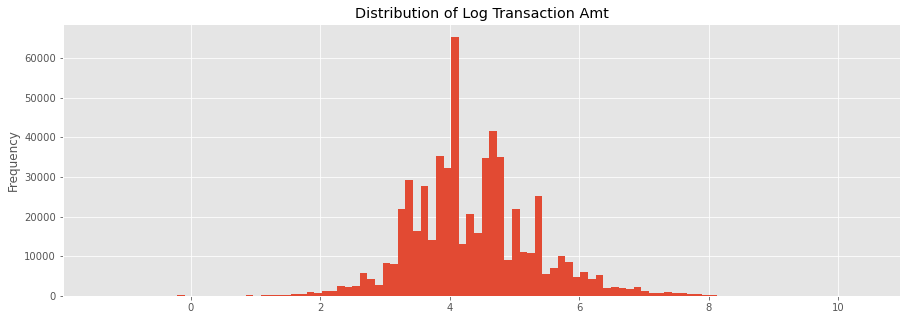

In [58]:
train_transaction.groupby("isFraud")["TransactionAmt"].apply(np.log).plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')

In [60]:
train_transaction.groupby("isFraud")["TransactionAmt"].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,569877.0,134.511665,239.395078,0.251,43.970,68.5,120.0,31937.391
1,20663.0,149.244779,232.212163,0.292,35.044,75.0,161.0,5191.000


Normal distribution in transaction amount with similar mean and std between fraud and non-fruad transaction